<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#DesicionTreeClassifier" data-toc-modified-id="DesicionTreeClassifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DesicionTreeClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Проект для «Викишоп»

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

**Описание данных:**

Столбец text в нём содержится комментарий, а toxic — целевой признак.

**Шаги выполнения проекта:**
1. Загрузка данных и подготовка
2. Обучение моделей
3. Итоговый вывод

In [1]:
RANDOM_STATE = 42
TEST_SIZE= 0.25

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import seaborn as sns
import lightgbm as lgb
import pandas as pd
from time import time
import logging
import warnings

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Загрузка и подготовка данных 

In [3]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Нет дубликатов и пропусков, дополнительная обработка не требуется

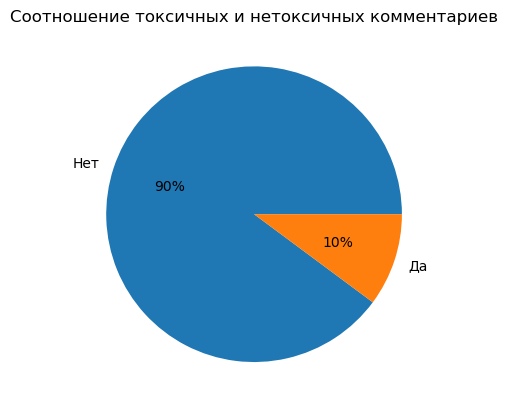

In [8]:
plt.pie(df.pivot_table(index='toxic', values='text', aggfunc='count')['text'], labels=['Нет', 'Да'], autopct='%.0f%%')
plt.title('Соотношение токсичных и нетоксичных комментариев');

Проведем клининг данных от не нужных символов

In [9]:
def cleaning(text):
    resub = re.sub(r'[^a-zA-Z]', ' ', text)
    resub_split = resub.split()
    
    return ' '.join(resub_split)

df['lemm_text'] = df['text'].apply(cleaning)

In [10]:
df['lemm_text'] = df['lemm_text'].apply(lambda x: x.lower())

Как можно заметить присутствует дизбаланс классов, что может повлиять на работу моделей

Проведем лемматизацию и сохраним ее в датафрейме

In [11]:
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper() 
    tag_dict = {
        'J': wordnet.ADJ, 
        'N': wordnet.NOUN,  
        'V': wordnet.VERB, 
        'R': wordnet.ADV, 
    } 
    return tag_dict.get(tag, wordnet.NOUN) 

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(lemmatized_words)

df['lemm_text'] = df['lemm_text'].apply(lemmatize)
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разобьем выборки на тренировочную, валидационную и тестовую и рассчитаем TFIDF

In [12]:
stopwords = list(nltk_stopwords.words('english'))

feature = df['lemm_text']
target = df['toxic']

X_train_valid, X_test, y_train_valid, y_test = train_test_split(feature, 
                                                                target, 
                                                                test_size=TEST_SIZE,
                                                                stratify=target,
                                                                random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                      y_train_valid, 
                                                      test_size=TEST_SIZE,
                                                      stratify=y_train_valid,
                                                      random_state=RANDOM_STATE)

**Промежуточные итоги:**

- Были загружены и изучены данные
- Проведена очистка текста от лишних символов
- Проведена и сохранена лемматизация текста
- Были разделены выборки
- Присутствует дизбаланс классов

## Обучение моделей

### LogisticRegression

In [13]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('model', LogisticRegression()),
    ]
)

param_grid = {
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
              'model__C': range(1, 10)
             }

grid_search = GridSearchCV(pipeline,
                           param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__C': range(1, 10),
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['lbfgs', 'liblinear', 'newton-cg']},
             scoring='f1')

In [14]:
print('Лучшая LogisticRegression и её параметры:\n', grid_search.best_estimator_['model'])
print('Метрика F1 для лучшей модели:\n', grid_search.best_score_)

Лучшая LogisticRegression и её параметры:
 LogisticRegression(C=3, penalty='l1', solver='liblinear')
Метрика F1 для лучшей модели:
 0.7791829391456997


Сохраним модель с гиперпараметрами

In [15]:
logistic = grid_search.best_estimator_
logistic_search_metric = grid_search.best_score_

In [16]:
start = time()
logistic.fit(X_train, y_train)
end = time()

logistic_time_fit = end - start

In [17]:
start = time()
logistic_valid_metric = f1_score(y_valid, logistic.predict(X_valid))
end = time()
logistic_time_predict = end - start
print(f'F1 на валидационной выборке: {logistic_valid_metric}')

F1 на валидационной выборке: 0.7728924418604651


### LightGBM

In [ ]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('model', lgb.LGBMClassifier(random_state=RANDOM_STATE)),
    ]
)
param_grid = {
    'model__boosting_type': ['gbdt', 'rf'],
    'model__max_depth': range(10, 15),
    'model__num_leaves': np.arange(20, 300, 20),
    'model__learning_rate': np.arange(0.1, 1, 0.2)
             } 

randomized_search = RandomizedSearchCV(pipeline,
                                       param_grid,
                                       scoring='f1',
                                       random_state=RANDOM_STATE,
                                       cv=3,
                                       n_jobs=-1)

randomized_search.fit(X_train, y_train)

In [19]:
print('Лучшая LightGBM и её параметры:\n', randomized_search.best_estimator_['model'])
print('Метрика F1 для лучшей модели:\n', randomized_search.best_score_)

Лучшая LightGBM и её параметры:
 LGBMClassifier(learning_rate=0.5000000000000001, max_depth=11, num_leaves=100,
               random_state=42)
Метрика F1 для лучшей модели:
 0.7462194267132861


In [20]:
light = randomized_search.best_estimator_
light_search_metric = randomized_search.best_score_

In [ ]:
start = time()
light.fit(X_train, y_train)
end = time()

light_time_fit = end - start

In [22]:
start = time()
light_valid_metric = f1_score(y_valid, light.predict(X_valid))
end = time()
light_time_predict = end - start
print(f'F1 на валидационной выборке: {light_valid_metric}')

F1 на валидационной выборке: 0.7439792515746573


### DesicionTreeClassifier

In [23]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('model', DecisionTreeClassifier()),
    ]
)
param_grid = {
    'model__max_depth': [None] + [i for i in range(2, 7)],
    'model__min_samples_split': [None] + [i for i in range(2, 7)],
    'model__min_samples_leaf': [None] + [i for i in range(2, 7)]
             }

randomized_search = RandomizedSearchCV(pipeline,
                                       param_grid,
                                       scoring='f1',
                                       random_state=RANDOM_STATE,
                                       cv=5,
                                       n_jobs=-1)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('model',
                                              DecisionTreeClassifier())]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 2, 3, 4, 5,
                                                             6],
                                        'model__min_samples_leaf': [None, 2, 3,
                                                                    4, 5, 6],
                                        'model__min_samples_split': [None, 2, 3,
                                                                     4, 5, 6]},
                   random_state=42, scoring='f1')

In [24]:
print('Лучшая DecisionTreeClassifier и её параметры:\n', randomized_search.best_estimator_['model'])
print('Метрика F1 для лучшей модели:\n', randomized_search.best_score_)

Лучшая DecisionTreeClassifier и её параметры:
 DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=4)
Метрика F1 для лучшей модели:
 0.7064715815068302


In [25]:
tree = randomized_search.best_estimator_
tree_search_metric = randomized_search.best_score_

In [26]:
start = time()
tree.fit(X_train, y_train)
end = time()

tree_time_fit = end - start

In [27]:
start = time()
tree_valid_metric = f1_score(y_valid, tree.predict(X_valid))
end = time()
tree_time_predict = end - start
print(f'F1 на валидационной выборке: {tree_valid_metric}')

F1 на валидационной выборке: 0.7015813637136541


### Выводы

In [28]:
models = pd.DataFrame({'Модель': [logistic['model'], light['model'], tree['model']],
                       'F1 при кросс-валидации': [logistic_search_metric, light_search_metric, tree_search_metric],
                       'F1 на валидационной выборке': [logistic_valid_metric, light_valid_metric, tree_valid_metric],
                       'Время обучения в с.': [logistic_time_fit, light_time_fit, tree_time_fit],
                       'Время прогнозирования в с.': [logistic_time_predict, light_time_predict, tree_time_predict]
                      })
models

,Модель,F1 при кросс-валидации,F1 на валидационной выборке,Время обучения в с.,Время прогнозирования в с.
0,"LogisticRegression(C=3, penalty='l1', solver='...",0.779183,0.772892,7.263692,1.403567
1,LGBMClassifier(learning_rate=0.500000000000000...,0.746219,0.743979,15.329720,1.430725
2,"DecisionTreeClassifier(min_samples_leaf=3, min...",0.706472,0.701581,159.253792,1.363423


LogisticRegression - лучшая модель из испытуемых по всем параметрам

In [29]:
f1 = f1_score(y_test, logistic.predict(X_test))
print(f'Метрика F1 на тестовой выборке: {f1}')

Метрика F1 на тестовой выборке: 0.7708049113233287


## Итоговый вывод

В ходе проекты были подобраны лучшие гиперпараметры для трех моделей: LightGBMClassifier, LogisticRegression, DecisionTreeClassifier, они были обучены на тестовый выборках и проводилось сравнение их показателей на валидационной, по которым **лучшая оказалась LogisticRegression. Полученная метрика на тестовой выборке > 0.75**

Параметры модели и ее метрика приведена ниже

In [30]:
final = pd.DataFrame({'Модель': logistic['model'],
                      'F1 на тестовой выборке': f1,
                      'F1 при кросс-валидации': [logistic_search_metric],
                      'F1 на валидационной выборке': [logistic_valid_metric],
                      'Время обучения в с.': [logistic_time_fit],
                      'Время прогнозирования в с.': [logistic_time_predict]
                     })
final

,Модель,F1 на тестовой выборке,F1 при кросс-валидации,F1 на валидационной выборке,Время обучения в с.,Время прогнозирования в с.
0,"LogisticRegression(C=3, penalty='l1', solver='...",0.770805,0.779183,0.772892,7.263692,1.403567
